100%|██████████| 30.0/30.0 [00:03<00:00, 8.91frame/s]


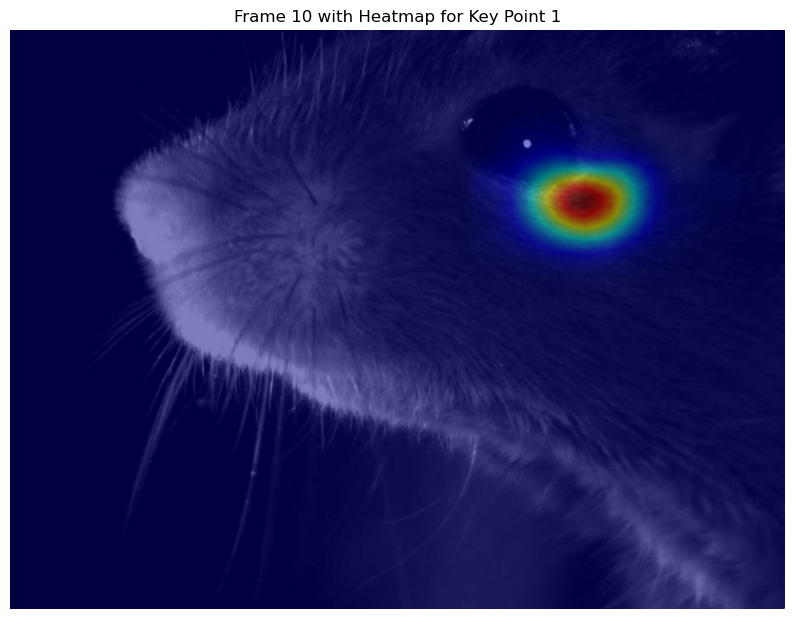

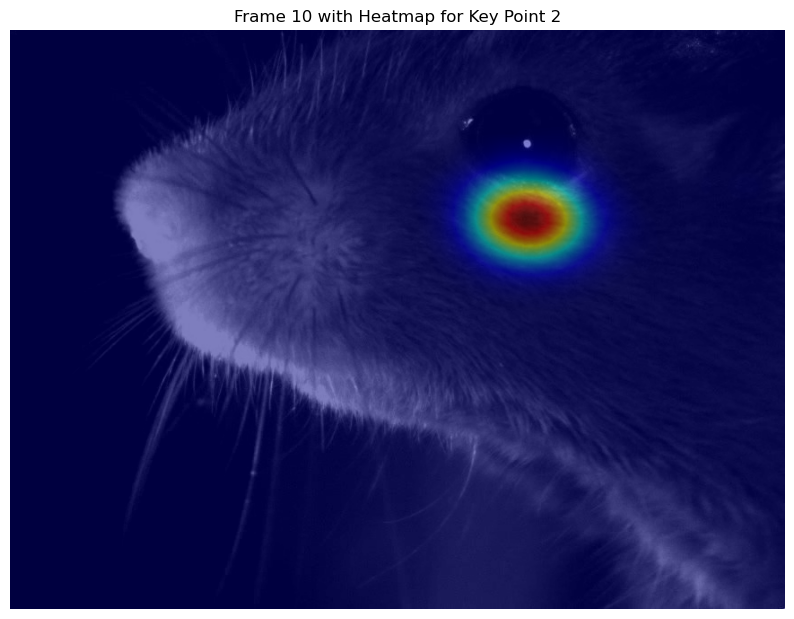

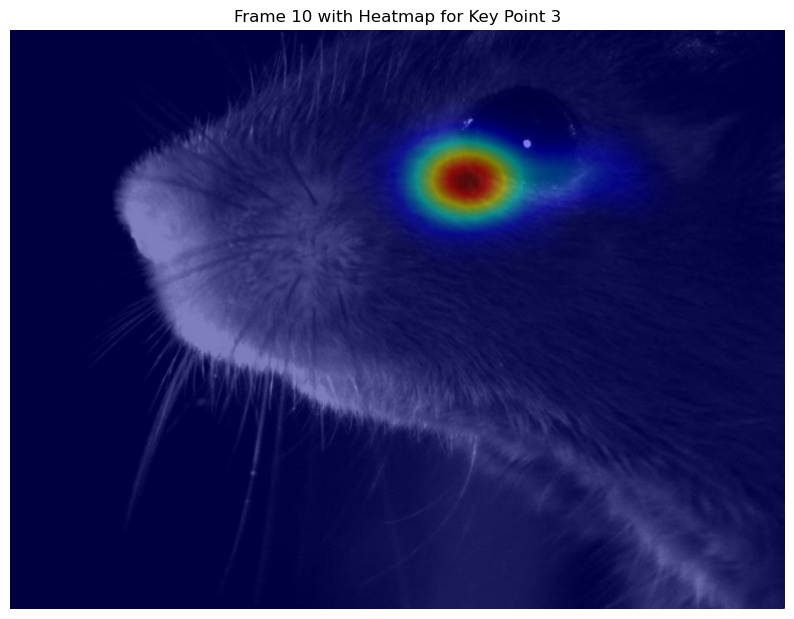

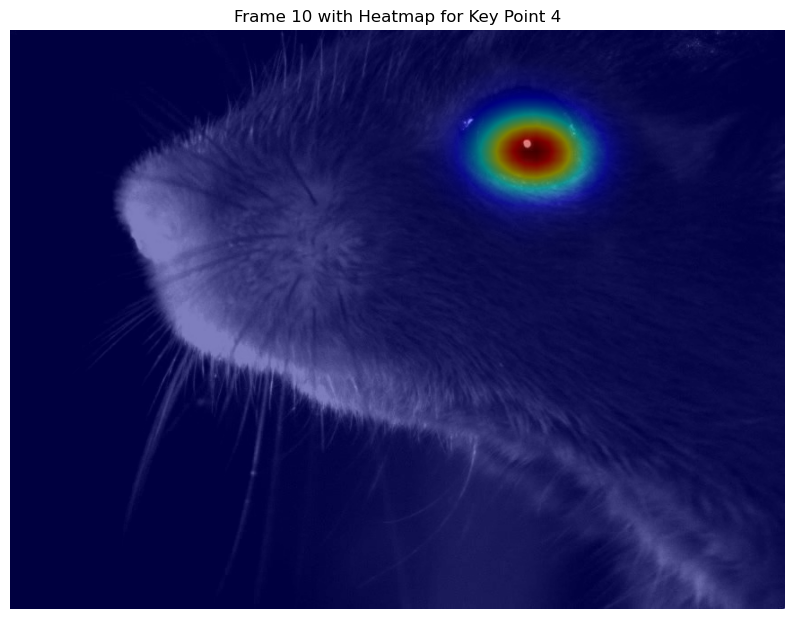

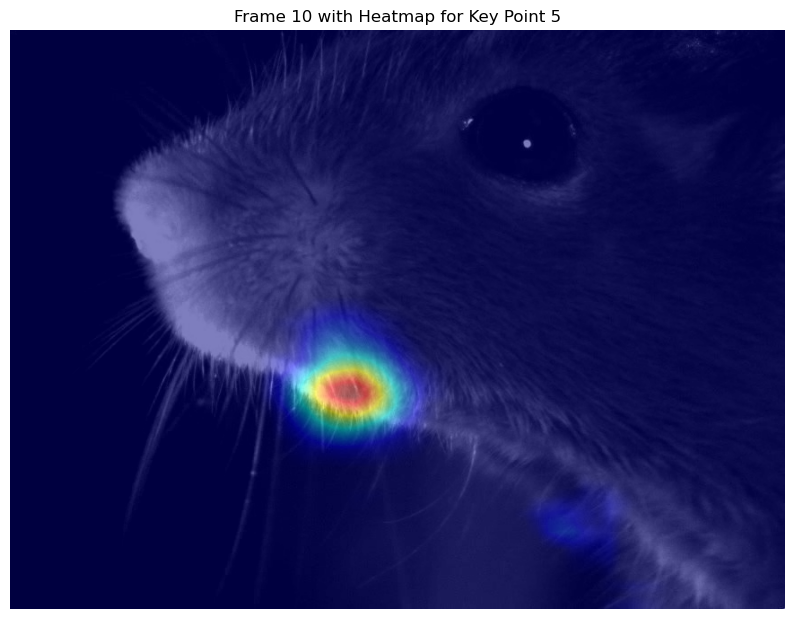

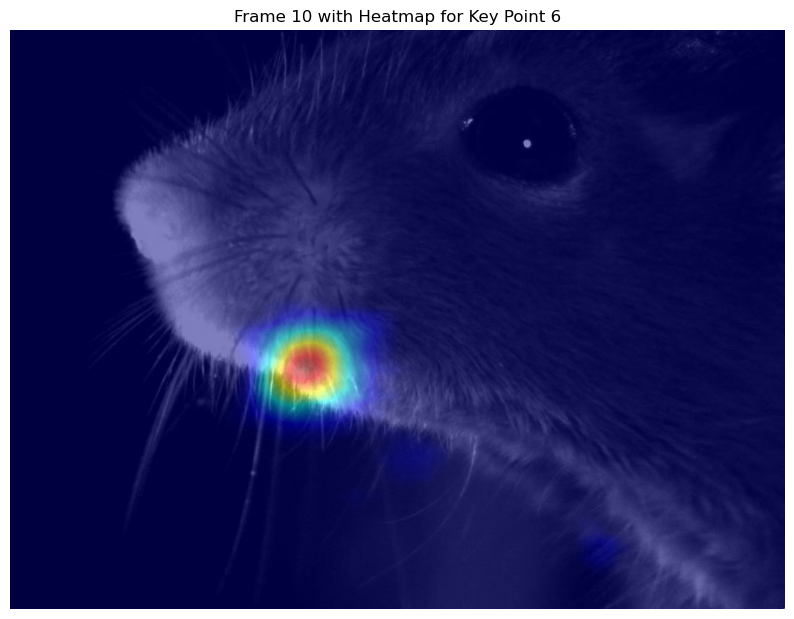

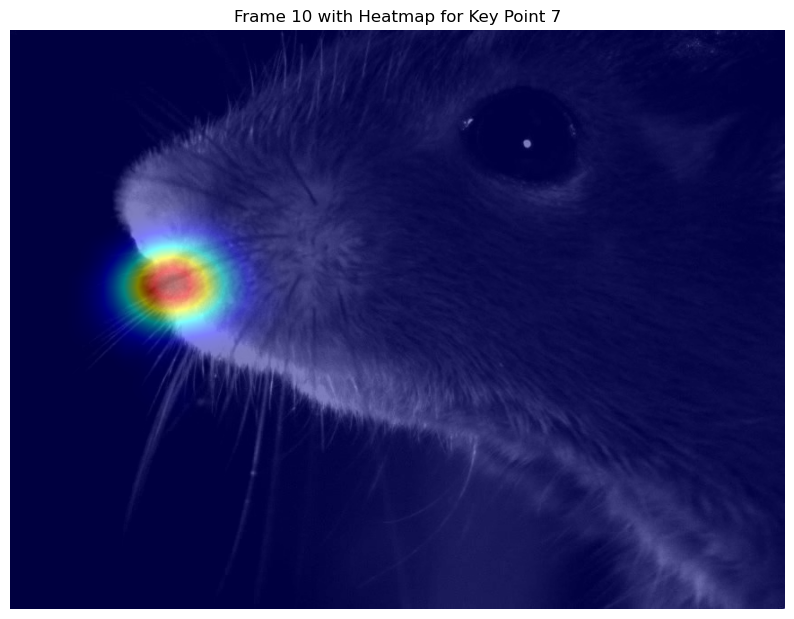

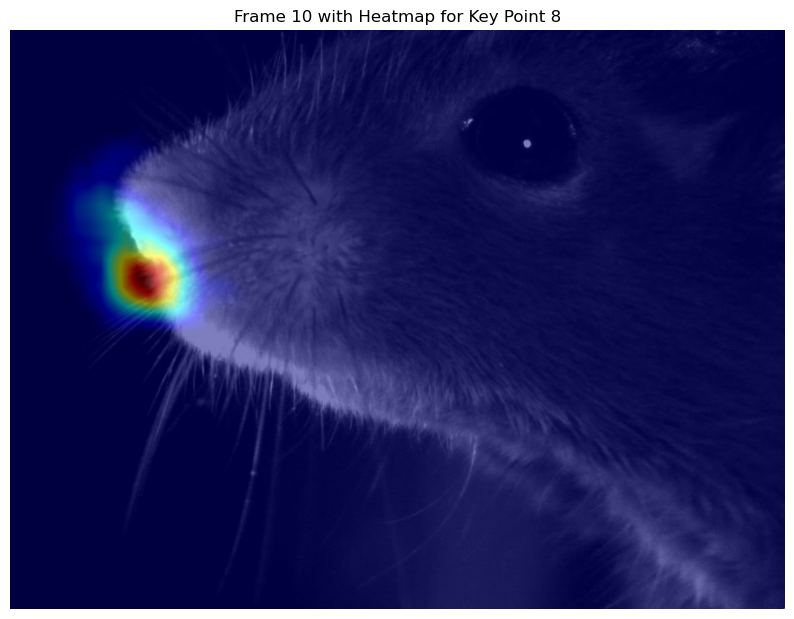

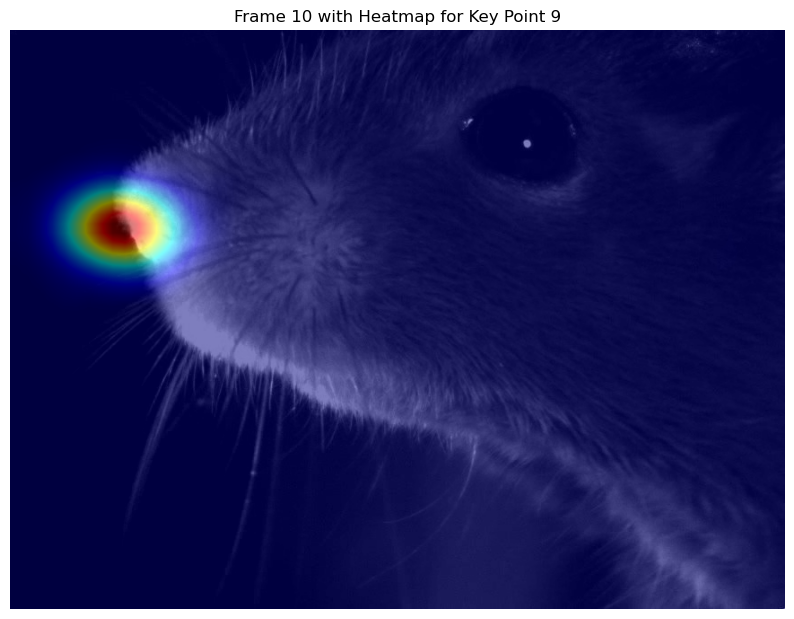

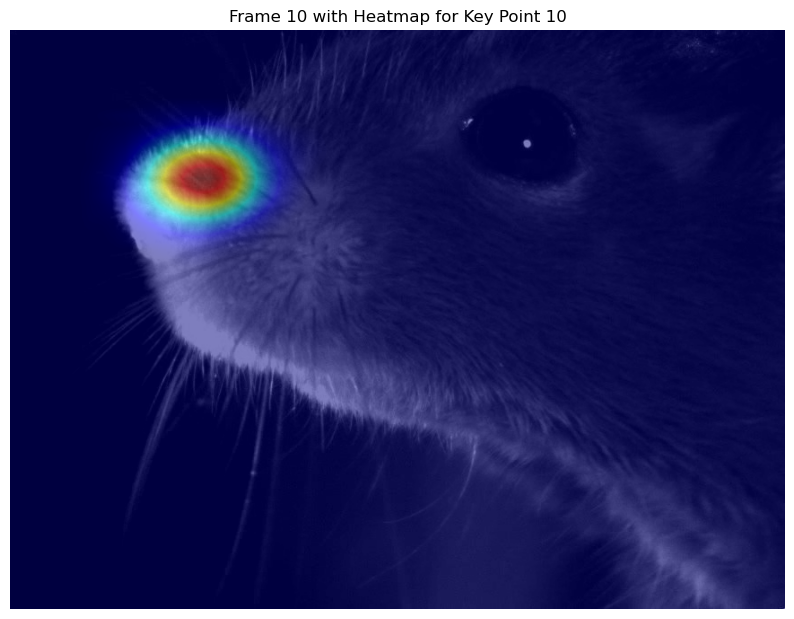

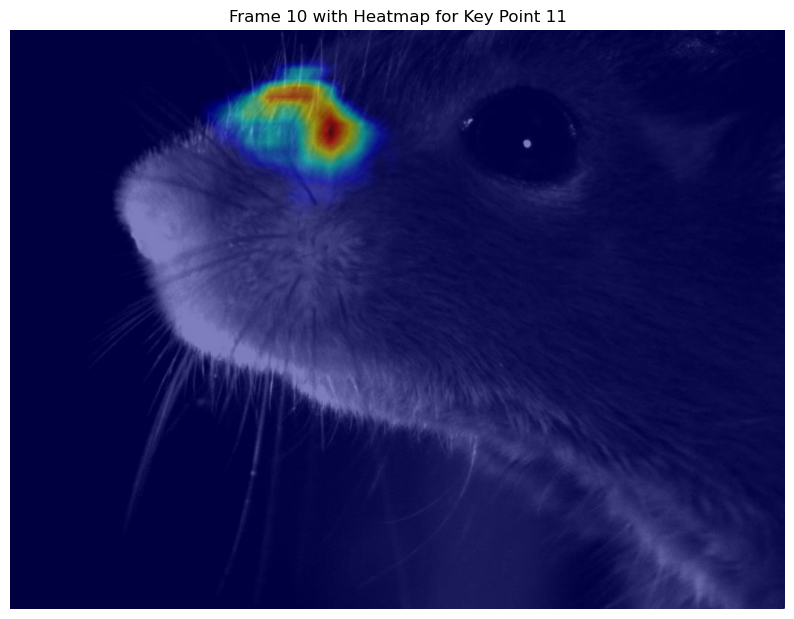

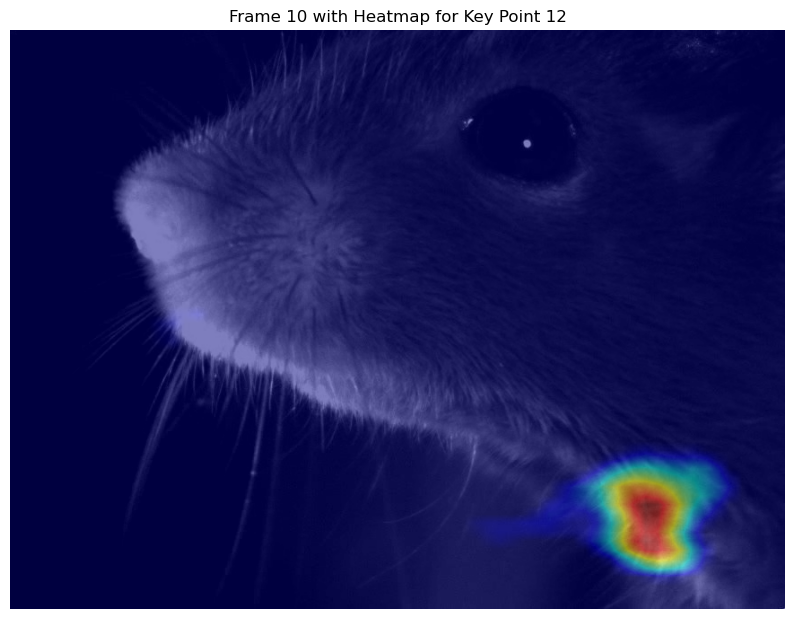

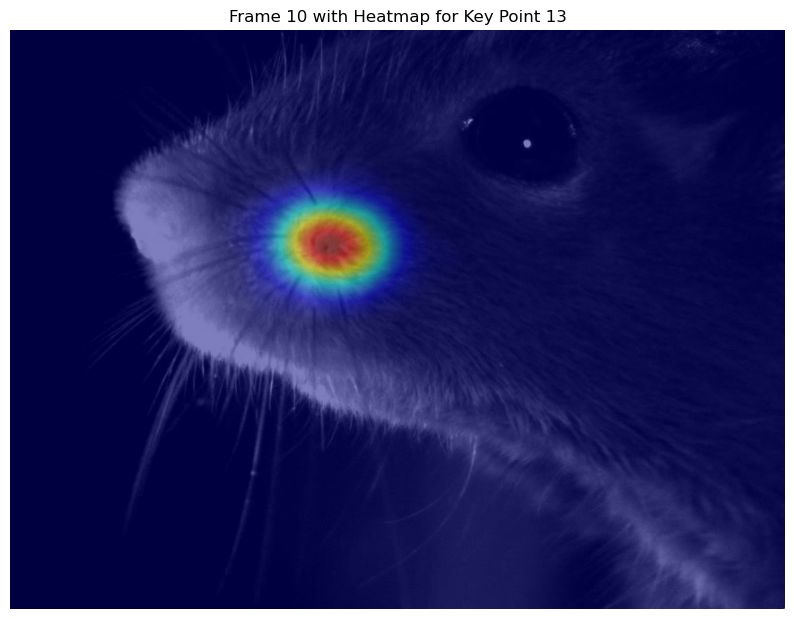

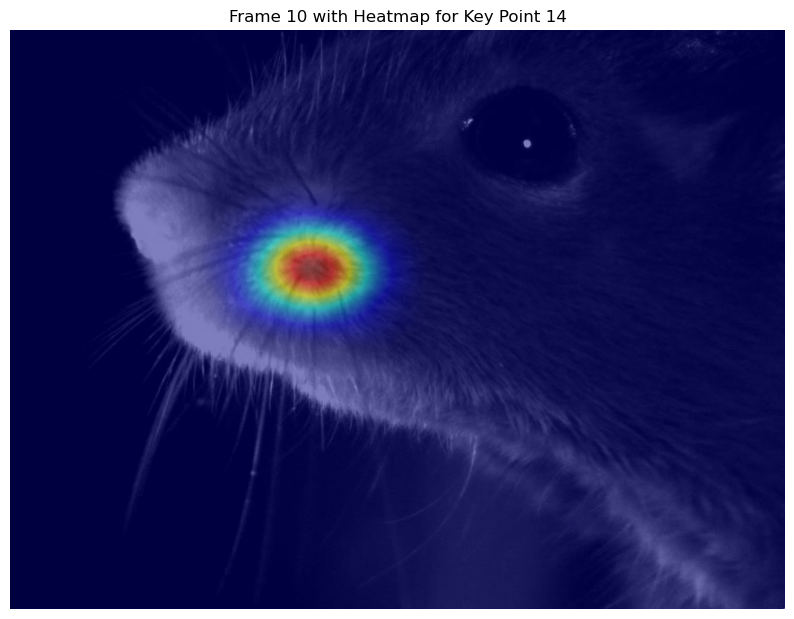

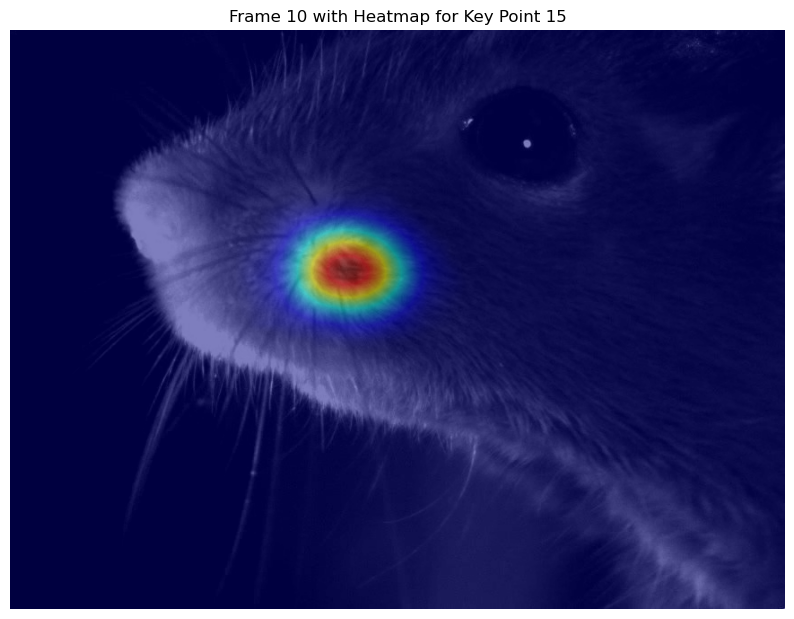

In [6]:
#VISUALIZE KPs

import matplotlib.pyplot as plt
import cv2
import numpy as np
from facemap.pose.pose import Pose  # Adjust the import path as needed

def visualize_keypoints_heatmaps(video_path, video_id, frame_index, pose_instance):
    """
    Visualize heatmaps for each key point sequentially on a specific video frame.

    Parameters:
        video_path (str): Path to the video file.
        video_id (int): Index of the video in Pose filenames.
        frame_index (int): Index of the frame to visualize.
        pose_instance (Pose): Instance of the Pose class.
    """
    # Run pose prediction
    pred_data, metadata = pose_instance.predict_landmarks(video_id)
    heatmaps = pose_instance.heatmaps.cpu().numpy()  # Ensure heatmaps are on CPU

    # Read the corresponding frame from the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error: Could not read frame {frame_index} from {video_path}")
        return

    # Convert frame to grayscale for visualization
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray_normalized = cv2.normalize(frame_gray, None, 0, 255, cv2.NORM_MINMAX)

    # Convert grayscale frame to three channels
    frame_gray_3channel = cv2.cvtColor(frame_gray_normalized, cv2.COLOR_GRAY2BGR)

    # Iterate over all key points (heatmaps for each keypoint)
    num_keypoints = heatmaps.shape[1]
    for kp_idx in range(num_keypoints):
        # Extract the heatmap for the current key point
        kp_heatmap = heatmaps[frame_index][kp_idx]

        # Resize heatmap to match the frame size
        resized_heatmap = cv2.resize(kp_heatmap, (frame_gray.shape[1], frame_gray.shape[0]))
        normalized_heatmap = cv2.normalize(resized_heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Create a color overlay from the heatmap
        heatmap_colored = cv2.applyColorMap(normalized_heatmap, cv2.COLORMAP_JET)

        # Blend the heatmap with the frame
        overlay = cv2.addWeighted(frame_gray_3channel, 0.5, heatmap_colored, 0.5, 0)

        # Display the frame with heatmap overlay
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_index} with Heatmap for Key Point {kp_idx + 1}")
        plt.axis("off")
        plt.show()

# Initialize Pose instance
video_file = "/Users/annastuckert/Documents/GitHub/facemap_MouseLand/cam1_G7c1_1_1second.avi"  # Update to your video path
pose_instance = Pose(
    filenames=[[video_file]],
    bbox=[],
    bbox_set=False,
    resize=False,
    add_padding=False,
    gui=None,
    GUIobject=None,
    net=None,
    model_name=None,
)

# Set up the pose prediction model
pose_instance.pose_prediction_setup()

# Visualize the heatmaps for all key points on a specific frame
visualize_keypoints_heatmaps(video_file, video_id=0, frame_index=10, pose_instance=pose_instance)


100%|██████████| 30.0/30.0 [00:03<00:00, 9.03frame/s]


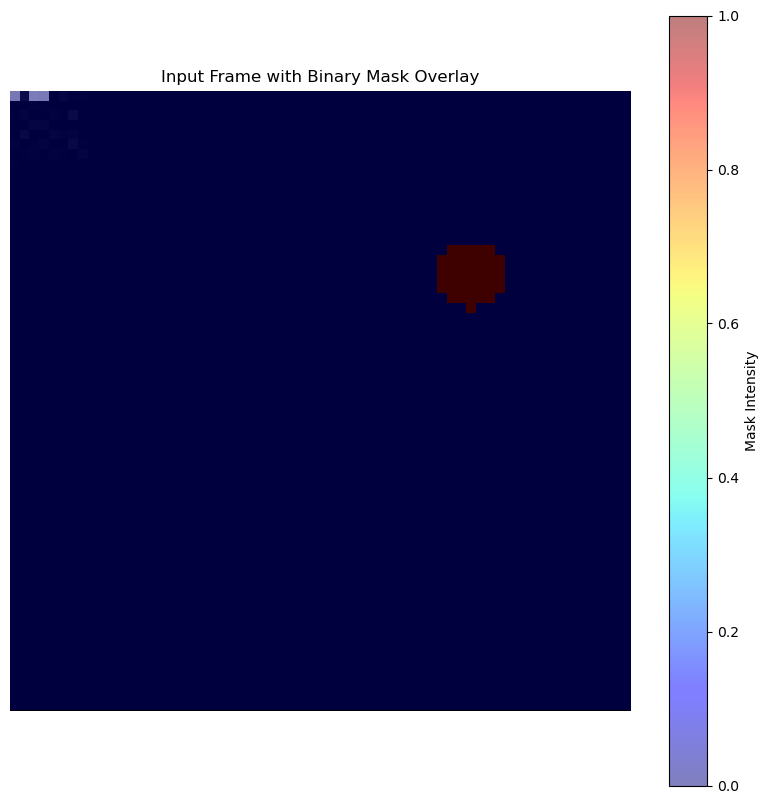

In [7]:
# GENERATE MASKS

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def generate_binary_mask(kp_heatmap, threshold=0.5):
    """
    Generate a binary mask from a heatmap using a threshold.

    Parameters:
        kp_heatmap (np.ndarray): Heatmap for a specific keypoint.
        threshold (float): Threshold value for binary mask creation.

    Returns:
        np.ndarray: Binary mask with values 0 and 1.
    """
    # Normalize the heatmap to [0, 1]
    normalized_heatmap = kp_heatmap / kp_heatmap.max()

    # Generate binary mask
    binary_mask = (normalized_heatmap > threshold).astype(float)

    return binary_mask


def visualize_binary_mask(input_frame, binary_mask):
    """
    Visualize the binary mask overlayed on the input frame.

    Parameters:
        input_frame (np.ndarray): Grayscale image frame.
        binary_mask (np.ndarray): Binary mask for overlay.
    """
    plt.figure(figsize=(10, 10))

    # Display the input frame
    plt.imshow(input_frame, cmap="gray", interpolation="nearest")

    # Overlay the binary mask
    plt.imshow(binary_mask, cmap="jet", alpha=0.5, interpolation="nearest")
    plt.colorbar(label="Mask Intensity")
    plt.title("Input Frame with Binary Mask Overlay")
    plt.axis("off")
    plt.show()


# Assuming 'pose_instance' is already set up and the model is loaded
video_file = "/Users/annastuckert/Documents/GitHub/facemap_MouseLand/cam1_G7c1_1_1second.avi"  # Replace with your video path
pose_instance = Pose(
    filenames=[[video_file]],
    bbox=[],
    bbox_set=False,
    resize=False,
    add_padding=False,
    gui=None,
    GUIobject=None,
    net=None,
    model_name=None,
)

# Run pose prediction setup
pose_instance.pose_prediction_setup()

# Predict landmarks and heatmaps
video_id = 0
pred_data, metadata = pose_instance.predict_landmarks(video_id=video_id)
heatmaps = pose_instance.heatmaps  # Access heatmaps from the object

# Example Usage
# Extract a heatmap for a specific key point and frame
frame_index = 10  # Adjust as needed
keypoint_index = 0  # First keypoint
kp_heatmap = heatmaps[frame_index][keypoint_index].cpu().numpy()

# Normalize and threshold to generate a binary mask
threshold = 0.5
binary_mask = generate_binary_mask(kp_heatmap, threshold=threshold)

# Open the video and extract the frame for visualization
cap = cv2.VideoCapture(video_file)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError(f"Could not read frame {frame_index} from {video_file}")

# Convert the frame to grayscale
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Visualize the binary mask overlayed on the input frame
visualize_binary_mask(frame_gray, binary_mask)

In [ ]:
# import cv2
# import numpy as np
# import torch
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from PIL import Image
# import matplotlib.pyplot as plt
# from facemap.pose.facemap_network import FMnet

# # Load a frame or an image as `input_image`
# video_file = "/Users/annastuckert/Documents/GitHub/facemap_MouseLand/cam1_G7c1_1_1second.avi"  # Replace with your video file path
# frame_index = 100  # Define the frame index you want to use

# # Capture the frame from the video
# cap = cv2.VideoCapture(video_file)
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
# ret, frame = cap.read()
# cap.release()

# if not ret:
#     raise ValueError(f"Could not read frame {frame_index} from {video_file}")

# # Convert the frame to grayscale and normalize
# frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# input_image = frame_gray / 255.0  # Normalize to [0, 1]

# # Add batch and channel dimensions to the input image
# input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
# input_tensor = input_tensor.float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# print(f"Input tensor shape: {input_tensor.shape}")

# # Define the SemanticSegmentationTarget class for single-channel output
# class SemanticSegmentationTarget:
#     def __init__(self, mask):
#         self.mask = torch.from_numpy(mask)
#         if torch.cuda.is_available():
#             self.mask = self.mask.cuda()
        
#     def __call__(self, model_output):
#         return (model_output[0, :, :] * self.mask).sum()

# # Initialize the model
# model = FMnet(
#     img_ch=1,
#     output_ch=1,  # Update based on your task
#     labels_id=["KP1", "KP2", "KP3"],  # Replace with your keypoint labels
#     channels=[8, 16, 32, 64],  # Update based on your configuration
#     device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
# ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# model.eval()

# # Define the target layer
# target_layers = [model.Conv[-1]]  # Replace with the desired target layer

# # Create a binary mask (e.g., based on keypoint heatmap)
# threshold = 0.5
# binary_mask = (input_image > threshold).astype(float)  # Example mask
# targets = [SemanticSegmentationTarget(binary_mask)]

# # Generate Grad-CAM
# with GradCAM(model=model, target_layers=target_layers) as cam:  # No use_cuda argument
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]  # First element in batch

# # Visualization
# rgb_img = np.repeat(input_image[:, :, None], 3, axis=-1)  # Convert grayscale to RGB
# cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# # Display the Grad-CAM result
# plt.figure(figsize=(10, 10))
# plt.imshow(cam_image)
# plt.title("Grad-CAM Visualization")
# plt.axis("off")
# plt.show()

# # Optionally save the Grad-CAM result as an image
# output_path = "grad_cam_result.png"
# Image.fromarray(cam_image).save(output_path)
# print(f"Grad-CAM result saved to {output_path}")


ValueError: Could not read frame 100 from /Users/annastuckert/Documents/GitHub/facemap_MouseLand/cam1_G7c1_1_1second.avi

100%|██████████| 30.0/30.0 [00:03<00:00, 8.56frame/s]


[243.62177 275.30103 218.84096 175.36412 531.7323  504.3012  370.12323
 363.77246 292.15686 217.56592 135.90263 698.1374  314.17313 353.49594
 352.68726]
[524.8444   462.03357  394.02744  468.0667   255.4801   211.98666
  62.492645  33.21982    9.574814  96.48265  227.6644   593.29877
 239.10669  224.7583   261.4604  ]
Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_1.png


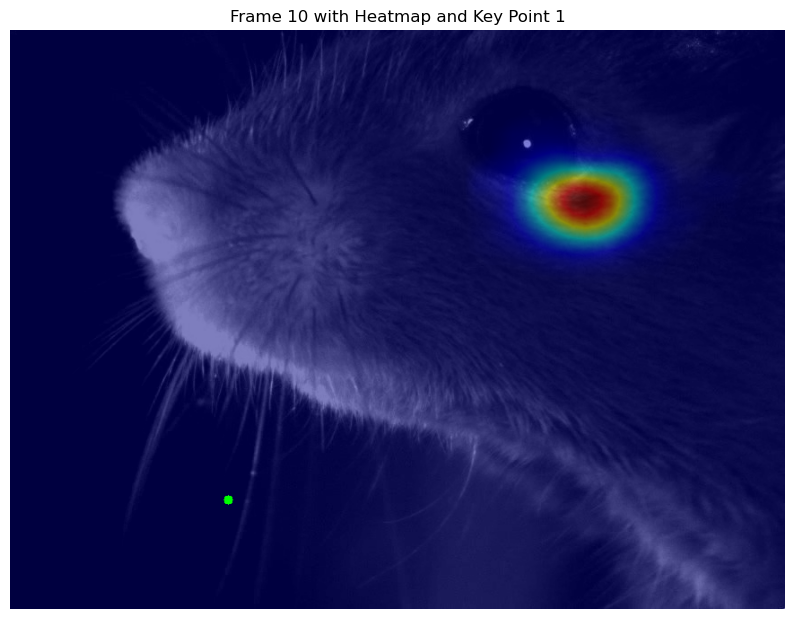

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_2.png


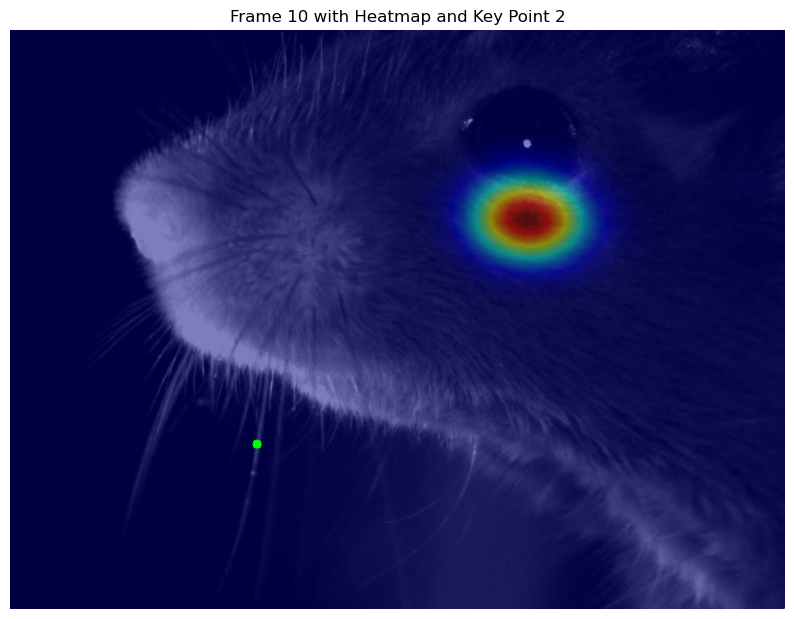

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_3.png


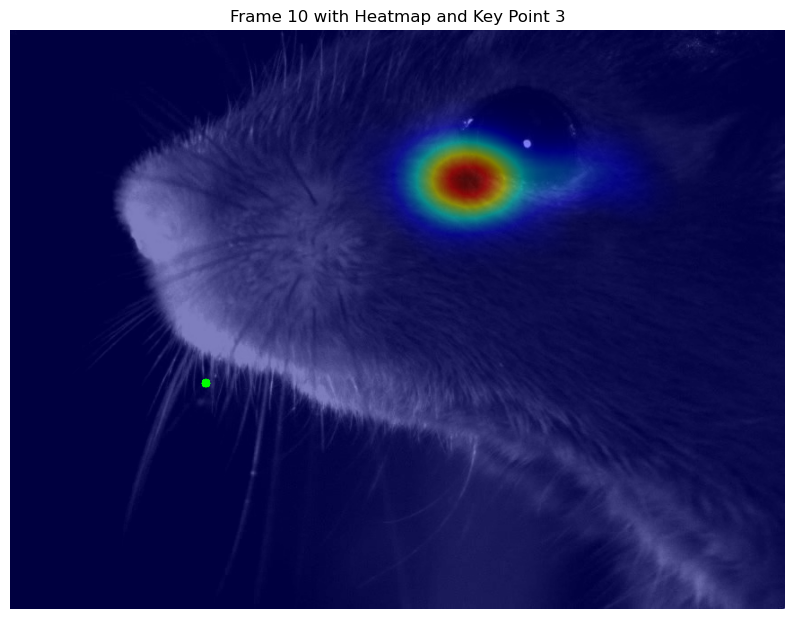

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_4.png


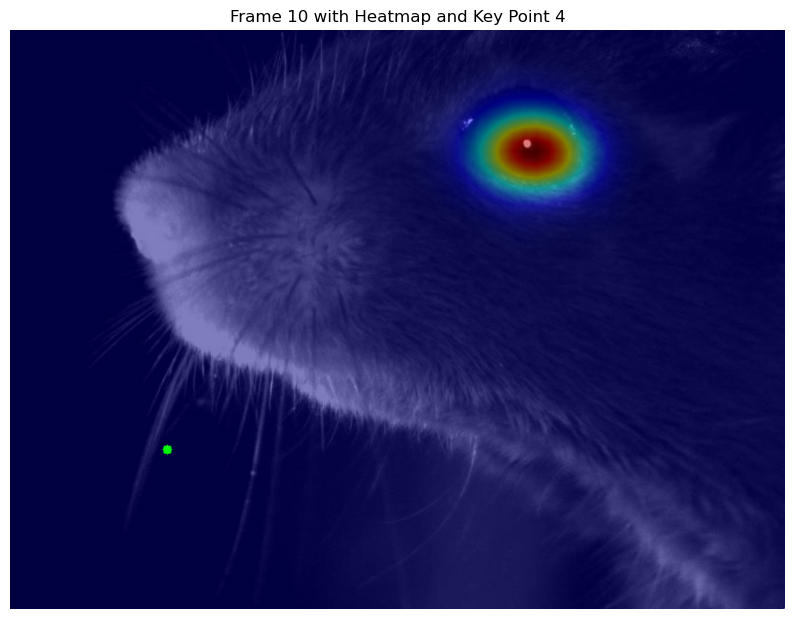

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_5.png


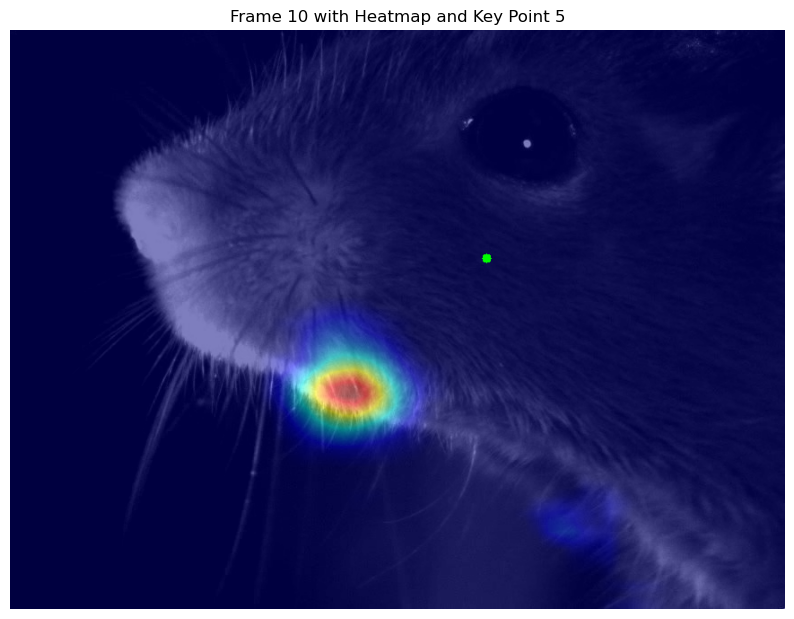

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_6.png


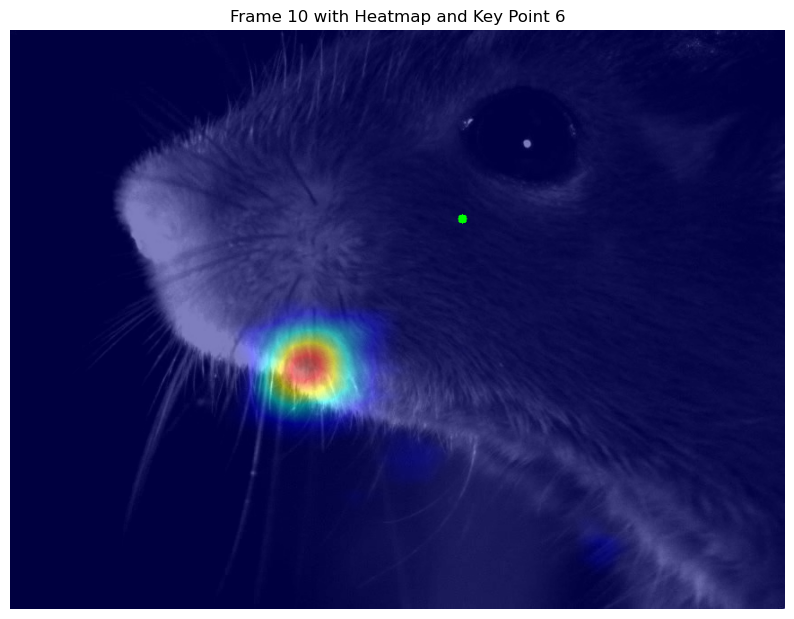

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_7.png


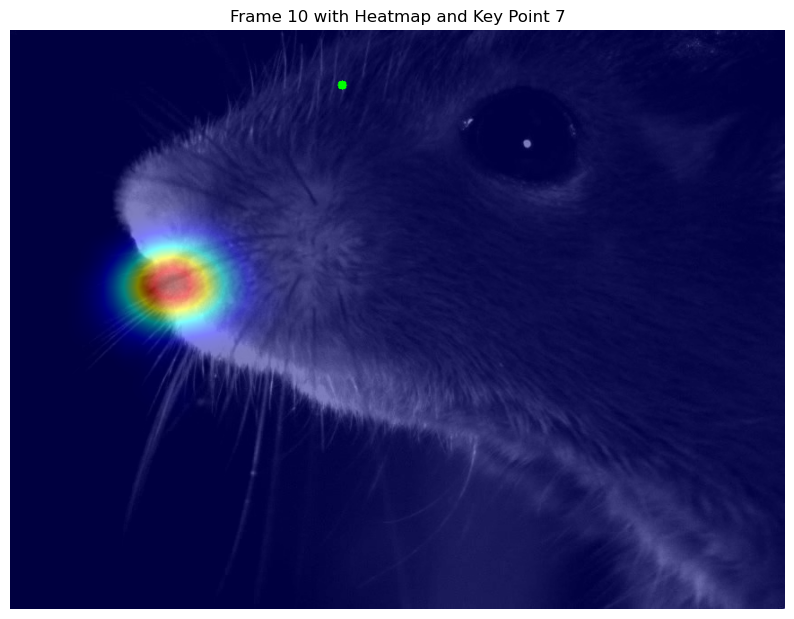

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_8.png


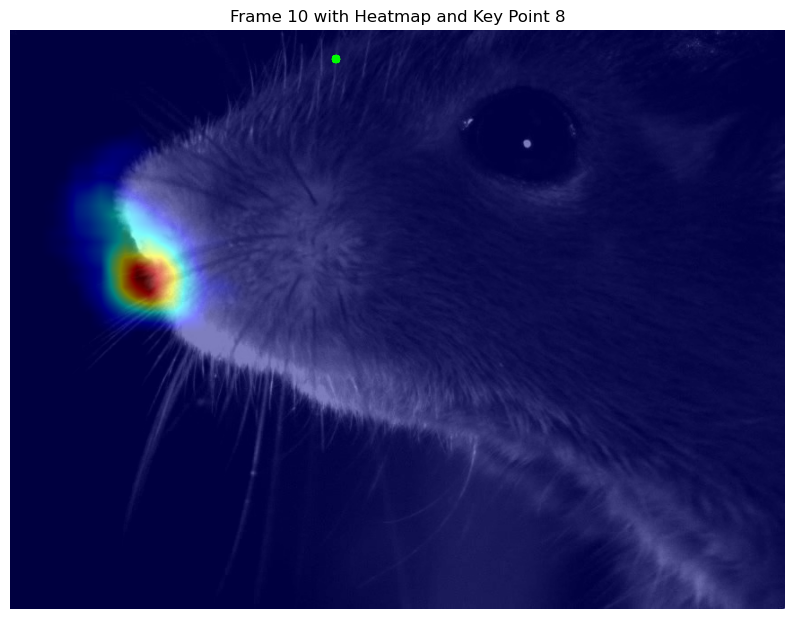

Saved heatmap with keypoints overlay: ./heatmaps/frame_10_kp_9.png


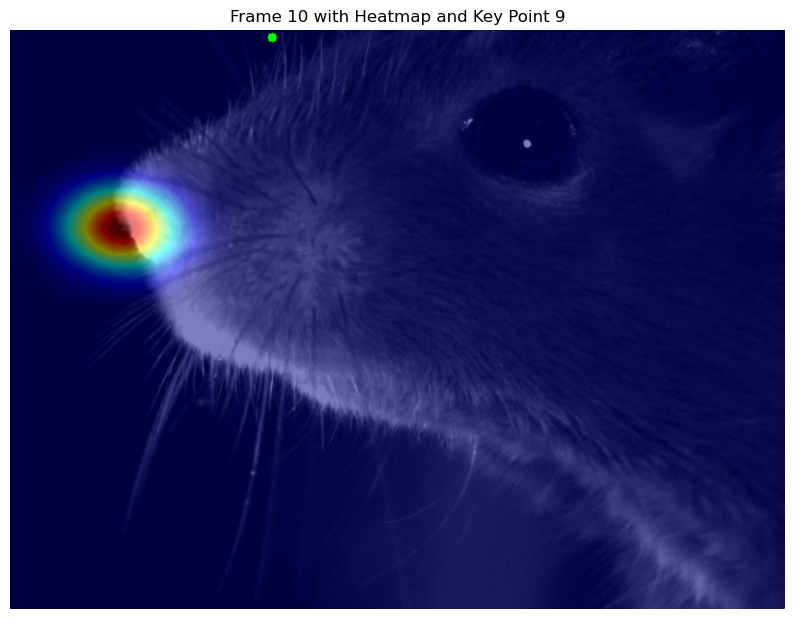

KeyboardInterrupt: 

In [ ]:
#Code form GradCAM for original UNet

import torch

# Add batch and channel dimensions
input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 224, 224]

# Ensure it's in the correct dtype and device (e.g., GPU if available)
input_tensor = input_tensor.float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print(f"Input tensor shape: {input_tensor.shape}")

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
from PIL import Image

# Define the SemanticSegmentationTarget class for single-channel output
class SemanticSegmentationTarget:
    def __init__(self, mask):
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        # For single-channel output, directly apply the mask
        return (model_output[0, :, :] * self.mask).sum()

model.eval()

# Set the target layer
target_layers = [model.model.uEnc3.enc2]  # Last layer of the deepest encoder block

# Define the target mask (binary or probabilistic)
targets = [SemanticSegmentationTarget(mask_float)]  # Pass the single-channel mask

# Initialize Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    # Generate the Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]  # First element in batch

    # Overlay the heatmap on the original image
    rgb_img = input_tensor[0, 0].cpu().numpy()  # Convert input to NumPy (grayscale image)
    rgb_img = np.repeat(rgb_img[:, :, None], 3, axis=-1)  # Convert to RGB
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
Image.fromarray(cam_image).show()

